<a href="https://colab.research.google.com/github/koleshjr/UmojaHack-Africa-2023-Carbon-Dioxide-Prediction-Challenge/blob/main/predicting_carbon_emission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UMOJA HACK BEGINNER CHALLENGE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


LOADING THE LIBRARIES

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
import os, sys, gc, warnings, random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
import lightgbm as lgb  
import catboost as catt
import xgboost as xgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import SplineTransformer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter('ignore')


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

LOADING THE DATA

In [ ]:
path = '/content/gdrive/MyDrive/Carbon_Emissions/'
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

REDUCING MEMORY FUNCTION

In [ ]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        
        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')
        
        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)  
        
    return df

In [ ]:
train = convert_types(train)
test = convert_types(test)

REMOVING NANS WITH MISSING VALUES GREATER THAN THE THRESH

In [ ]:
def remove_nans(train,thresh) :
  def nans_rate(train,col) :
    return train[col].isna().sum() / train.shape[0]

  for col in train.columns : 
    if nans_rate(train,col) >= thresh :
      train.drop(col,axis=1,inplace=True)
  return train

In [ ]:
train = remove_nans(train,thresh=0.8)
test = test[train.columns[:-1]]

In [ ]:
train.shape, test.shape

((74005, 69), (28085, 68))

### Feature Engineering
* Created location feature
* Created Month Feature useful in cross validation as we saw in the EDA
* Dropped all angle, altitude, depth and height columns because they had a low correlation to the target as seen in the starter notebook
* Extracted trigonometric features and periodic spline based features to capture the cycles - inspired by David Nkosana's winning notebook in Air Quality
* Created rolling means of 17, 39 and 52 weeks to capture the trend seen in the EDA notebook
* Created location based statistics , means, stds, min e.t.c - My reasoning behind this since test and train come from diff distributions , if we create the stats , and different locations share the same stats then CO2 emissions would likely be the same too right ? -> This was the gold feature for me 
* Dropped latitude, longitude and location - to take care of the diff train/test distribution problem

In [ ]:
def process(train , test) :
    data = pd.concat([train,test])
    data.latitude, data.longitude = round(data.latitude, 2), round(data.longitude, 2)
    data['location'] = [str(x) + '_' + str(y) for x, y in zip(data.latitude, data.longitude)]
    data = data.sort_values(by = ['location', 'year', 'week_no'])
    angle_cols = [col for col in data.columns if 'angle' in col or 'altitude' in col or 'depth' in col or 'height' in col]
    shift_cols = [col for col in data.columns if col not in angle_cols + ['ID_LAT_LON_YEAR_WEEK','year_week','longitude','latitude','emission','year_month','month','latitude','longitude' 'location','location','bin','year','week_no',]]    
    def sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period *2 * np.pi))

    def cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    def periodic_spline_transformer(period, n_splines=None, degree=3):
        if n_splines is None:
            n_splines = period
        n_knots = n_splines + 1 # periodoc and include bias = True
        return SplineTransformer(degree=degree,
                                n_knots=n_knots,
                                knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
                                extrapolation="periodic",
                                include_bias=True)    
   
    def getMonth(year: int, week: int) -> int:
        
        """Return the month number in the given week in the given year."""
        return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").month
    data['month'] = data.apply(lambda x: getMonth(x['year'], x['week_no']), axis=1)
    
    
        # Extract trigonometric features
    data["month_sin"] = sin_transformer(12).fit_transform(data["month"])
    data["month_cos"] = cos_transformer(12).fit_transform(data["month"])



    # Extract periodic spline-based features
    spline_cols_month = [f"cyclic_month_spline_{i}" for i in range(1, 7)]
    

    data[spline_cols_month] = periodic_spline_transformer(12, n_splines=6).fit_transform(np.array(data.month).reshape(-1,1))
    
    

    



 
    for col in shift_cols:
        data[f"{col}_rolling_mean_39"] = data[col].rolling(window=39).mean()
        data[f"{col}__rolling_max_39"] = data[col].rolling(window=39).max()
        data[f"{col}__rolling_min_39"] = data[col].rolling(window=39).min()
        data[f"{col}__rolling_sum_39"] = data[col].rolling(window=39).sum()
        data[f"{col}__rolling_std_39"] = data[col].rolling(window=39).std()
        data[f"{col}__rolling_skew_39"] = data[col].rolling(window=39).skew()
        
        data[f"{col}_rolling_mean_52"] = data[col].rolling(window=52).mean()
        data[f"{col}__rolling_max_52"] = data[col].rolling(window=52).max()
        data[f"{col}__rolling_min_52"] = data[col].rolling(window=52).min()
        data[f"{col}__rolling_sum_52"] = data[col].rolling(window=52).sum()
        data[f"{col}__rolling_std_52"] = data[col].rolling(window=52).std() 
        data[f"{col}__rolling_skew_52"] = data[col].rolling(window=52).skew() 
        
        data[f"{col}_rolling_mean"] = data[col].rolling(window=17).mean()
        data[f"{col}__rolling_max"] = data[col].rolling(window=17).max()
        data[f"{col}__rolling_min"] = data[col].rolling(window=17).min()
        data[f"{col}__rolling_sum"] = data[col].rolling(window=17).sum()
        data[f"{col}__rolling_std"] = data[col].rolling(window=17).std() 
        data[f"{col}__rolling_skew"] = data[col].rolling(window=17).skew() 




        
        data[f"{col}__location_mean"] = data.groupby(['location'])[col].transform('mean')
        data[f"{col}__location_std"] = data.groupby(['location'])[col].transform('std')
        data[f"{col}__location_min"] = data.groupby(['location'])[col].transform('min')
        data[f"{col}__location_max"] = data.groupby(['location'])[col].transform('max')
        data[f"{col}__location_skew"] = data.groupby(['location'])[col].transform('skew')
        

        
    for col in ['location']:
        data[col] = le.fit_transform(data[col])
        
    data = data.drop(columns = angle_cols + ['longitude','latitude'])
        
    
            



    




    train = data[data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]

    test = data[~data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]
    


    return train , test

In [ ]:
train , test = process(train , test)

In [ ]:
train.shape, test.shape

((74005, 686), (28085, 686))

In [ ]:
display(train.head(), test.head())

,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.73_28.77_2019_1,2019,1,0.000167,0.713379,0.000102,0.223877,0.000033,0.023407,2830.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
1,ID_-23.73_28.77_2019_2,2019,2,-0.000155,0.812988,-0.000137,0.080261,-0.000067,0.024185,2136.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
2,ID_-23.73_28.77_2019_3,2019,3,-0.000065,0.860352,-0.000062,0.161011,-0.000031,0.023697,1908.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
3,ID_-23.73_28.77_2019_4,2019,4,0.000152,0.422363,0.000087,0.046509,0.000031,0.022354,2122.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
4,ID_-23.73_28.77_2019_5,2019,5,0.000024,1.004883,0.000028,0.214233,0.000005,0.023041,1750.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793


,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.53_27.47_2019_1,2019,1,0.000077,0.454590,0.000034,0.114319,0.000015,0.025940,2344.0,...,NaN,NaN,NaN,NaN,NaN,0.218872,0.054245,0.12561,0.373779,0.56543
1,ID_-23.53_27.47_2019_2,2019,2,0.000181,0.423096,0.000062,0.075073,0.000024,0.025040,2188.0,...,NaN,NaN,NaN,NaN,NaN,0.218872,0.054245,0.12561,0.373779,0.56543
2,ID_-23.53_27.47_2019_3,2019,3,0.000059,0.712891,0.000043,0.114197,0.000020,0.025024,2314.0,...,NaN,NaN,NaN,NaN,NaN,0.218872,0.054245,0.12561,0.373779,0.56543
3,ID_-23.53_27.47_2019_4,2019,4,0.000483,0.434570,0.000171,0.131348,0.000068,0.022354,2068.0,...,NaN,NaN,NaN,NaN,NaN,0.218872,0.054245,0.12561,0.373779,0.56543
4,ID_-23.53_27.47_2019_5,2019,5,0.000193,0.783203,0.000141,0.161133,0.000065,0.023575,1995.0,...,NaN,NaN,NaN,NaN,NaN,0.218872,0.054245,0.12561,0.373779,0.56543


Modelling

In [ ]:
train = train.sort_values(by = ['location','year','week_no'])
test = test.sort_values(by = ['location','year','week_no'])
train.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.73_28.77_2019_1,2019,1,0.000167,0.713379,0.000102,0.223877,0.000033,0.023407,2830.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
1,ID_-23.73_28.77_2019_2,2019,2,-0.000155,0.812988,-0.000137,0.080261,-0.000067,0.024185,2136.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
2,ID_-23.73_28.77_2019_3,2019,3,-0.000065,0.860352,-0.000062,0.161011,-0.000031,0.023697,1908.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
3,ID_-23.73_28.77_2019_4,2019,4,0.000152,0.422363,0.000087,0.046509,0.000031,0.022354,2122.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793
4,ID_-23.73_28.77_2019_5,2019,5,0.000024,1.004883,0.000028,0.214233,0.000005,0.023041,1750.0,...,NaN,NaN,NaN,NaN,NaN,0.214844,0.053963,0.120361,0.462646,0.862793


In [ ]:
# Selecting the independent variables and the target variable
from sklearn.model_selection import train_test_split
X = train.drop(['ID_LAT_LON_YEAR_WEEK','emission','location'], axis = 1).fillna(0)
y = train.emission



MODELLING USING STRATIFIED KFOLD 
* I used Month column because , In my EDA I found that other than different locations, the test and train were splitted according to the Month


In [ ]:
from sklearn.preprocessing import StandardScaler,RobustScaler
fold_pred=[]
oof_pred = []



params1 = {'learning_rate': 0.15592472218053005, 'subsample': 0.9072713541530352, 'colsample_bytree': 0.5062834624362592, 'max_depth': 12,
 'objective':'rmse'}
        

    





fold= StratifiedKFold(n_splits=12)
i=1
for train_index, test_index in fold.split(X,X['month']):      
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = lgb.LGBMRegressor(**params1, n_estimators = 3050)

    model.fit(X_train,y_train,eval_set=[(X_test ,y_test)], early_stopping_rounds=120, verbose = 250)#erly100

    preds= model.predict(X_test,num_iteration=model.best_iteration_ )
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds), squared=False))
    p2 = model.predict(test[X.columns],num_iteration=model.best_iteration_)
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

err:  2656.1143457981793
err:  1796.4232744435592
[250]	valid_0's rmse: 4635.66
err:  1547.739581914256
[250]	valid_0's rmse: 181239
err:  177139.11707699802
[250]	valid_0's rmse: 22843.5
[500]	valid_0's rmse: 22843.5
err:  5958.483900586777
[250]	valid_0's rmse: 3019.04
[500]	valid_0's rmse: 3019.04
err:  2717.7525055528313
err:  1540.3658010802978
err:  7469.133812528944
[250]	valid_0's rmse: 6216.49
[500]	valid_0's rmse: 6216.48
err:  3197.310649429722
err:  11078.11573378293
[250]	valid_0's rmse: 2385.39
[500]	valid_0's rmse: 2385.39
err:  1884.166454617058
err:  8820.779037523724
18817.125181188025


20350.844524786546 - 19206.162602812623 - 18815

Text(0.5, 1.0, 'Lightgbm features importance (top 50):')

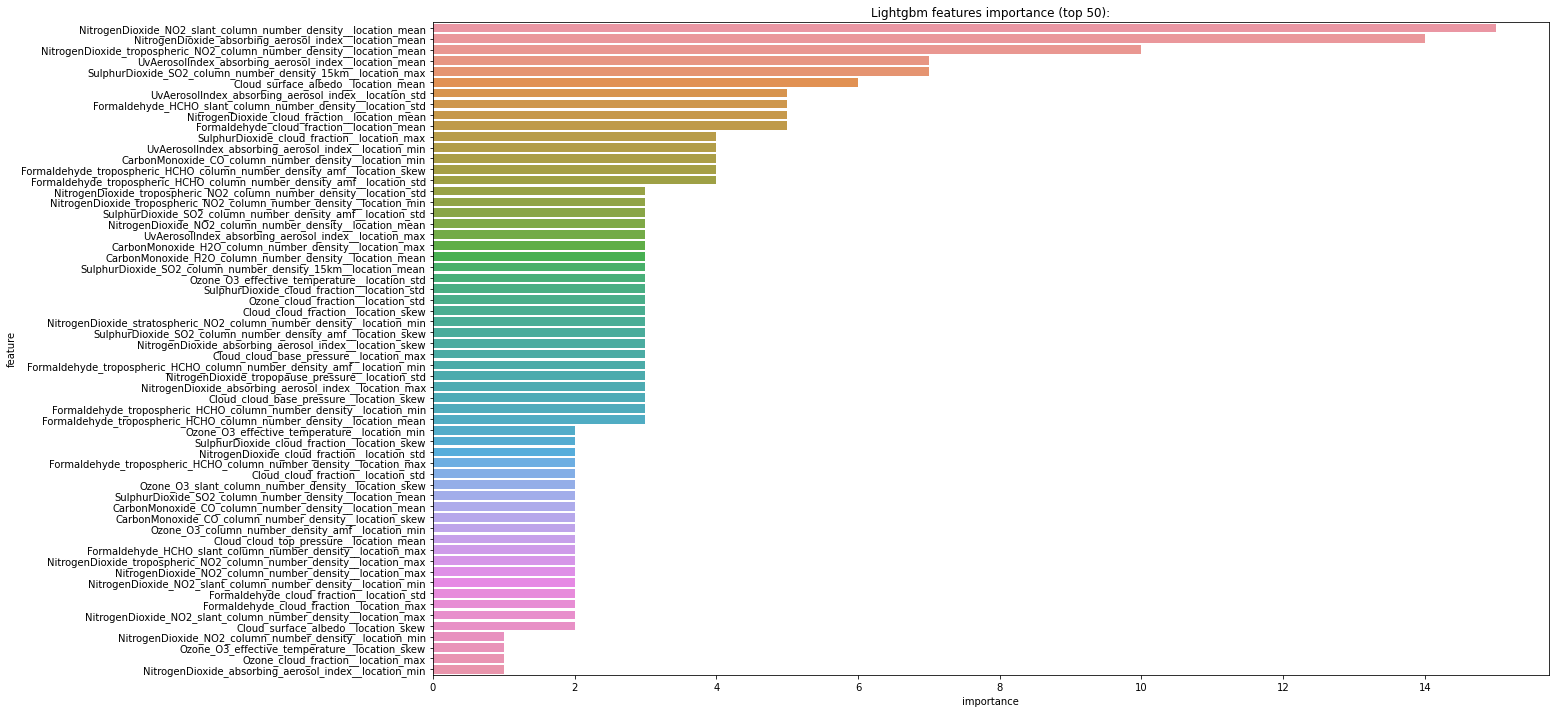

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Lightgbm features importance (top 50):')

In [ ]:
preds = np.mean(fold_pred,axis=0)
subb_2 = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test['ID_LAT_LON_YEAR_WEEK'],
    'target': preds
})


subb_2.target.describe()

count    28085.000000
mean      3622.301043
std       4328.680648
min        271.533632
25%        873.181186
50%       1803.782113
75%       4977.050796
max      27548.745495
Name: target, dtype: float64

In [ ]:
subb_2.to_csv(path + 'lgb_1881.csv', index = False)

### CatBoost

In [ ]:
import catboost as catt
cb_model = catt.CatBoostRegressor(iterations=5000,
                             learning_rate=0.045,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                            bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=300)
cb_model.fit(X, y,
             use_best_model=True,
             verbose=2000)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 50414.0290013	total: 1.23s	remaining: 1h 42m 5s
2000:	learn: 263.0582936	total: 24m 49s	remaining: 37m 13s
4000:	learn: 144.4793287	total: 49m 46s	remaining: 12m 25s
4999:	learn: 118.4986885	total: 1h 2m 15s	remaining: 0us


In [ ]:
preds = (cb_model.predict(test[X.columns]))

prediction = preds
prediction[prediction < 0] = 0

submission = pd.DataFrame()
submission['ID_LAT_LON_YEAR_WEEK'] = test['ID_LAT_LON_YEAR_WEEK']
submission['target'] = prediction
submission.to_csv(path + "CatBoost_5000.csv", index=False)
submission.head()



AVERAGE ENSEMBLE
* This gave me a very huge boostttt
* Not necessarily the ensemble technique I used but this does the trick tooooo

In [ ]:
import pandas as pd
two = pd.read_csv(path + 'CatBoost_5000.csv')
one = pd.read_csv(path + 'lgb_1881.csv')

ens = one.copy()

ens['target'] = one['target']*0.5  + two['target']*0.5

ens.to_csv(path + 'winning_submission.csv',index=False)
ens['target'].describe()



count    28085.000000
mean      5286.756459
std       6333.608466
min          0.000000
25%       1281.759158
50%       2953.115805
75%       6796.713966
max      40901.395448
Name: target, dtype: float64

count    28085.000000
mean      5286.756459
std       6333.608466
min          0.000000
25%       1281.759158
50%       2953.115805
75%       6796.713966
max      40901.395448
Name: target, dtype: float64